In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
params = {"axes.labelsize": 14,
          "axes.titlesize": 16,}
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update(params)

def place(ax):
  ax.tick_params(direction="in", which="minor", length=3)
  ax.tick_params(direction="in", which="major", length=5, labelsize=13)
  ax.grid(which="major", ls="dashed", dashes=(1, 3), lw=0.8, zorder=0)
  fig.tight_layout()


training_data_path = "../../../bui2026-dielectrocapillarity/training-data/"
simData1 = np.load(training_data_path + "water_T450_T900_coswave.npy", allow_pickle=True).item()
simData2 = np.load(training_data_path + "water_T500_T900_coswave.npy", allow_pickle=True).item()
simData3 = np.load(training_data_path + "water_T500_coswave.npy", allow_pickle=True).item()
simData4 = np.load(training_data_path + "water_T900_coswave.npy", allow_pickle=True).item()

simData = {}

for key in ['training', 'validation', 'test']:
    combined_data = {}
    datasets = [simData1, simData2, simData3, simData4]
    
    # Combine the data for the current set
    for i, simData in enumerate(datasets, start=1):
        for inner_key, value in simData.get(key, {}).items():
            
            combined_data[f"{inner_key}_{i}"] = value
        
    simData[key] = combined_data

def combine_data(xbins, elec, elec_grad, rho_O, mu_O, muloc_O, c1_O, n):
    data = {}
    
    data = np.zeros(xbins.shape, dtype=[('xbins', 'f8'), ('elec', 'f8'), ('elec_grad', 'f8'),  ('n', 'f8'), 
                                        ('rho_O', 'f8'), ('muloc_O', 'f8'), ('c1_O_scaledT', 'f8'), ('mu_O', 'f8')])
    
    data['xbins'] = xbins
    data['elec'] = elec
    data['elec_grad'] = elec_grad
    data['rho_O'] = rho_O
    data['mu_O'] = mu_O
    data['muloc_O'] = muloc_O
    data['elec'] = elec
    data['elec_grad'] = elec_grad
    data['c1_O_scaledT'] = c1_O
    data['n'] = n
    
    # set n to zero if all of elec is zero
    if np.all(elec_grad == 0):
        data['n'] = np.zeros_like(n)
        print("Setting n to zero")
    
    return data



# Combine all simulations into one list
all_simulations = []
for category in ['training', 'validation', 'test']:
    all_simulations.extend(list(simData[category].keys()))



# Add flip simulations
for sim in all_simulations:
    category = next(cat for cat in simData if sim in simData[cat])
    data = simData[category][sim]
    xbins = np.flip(data['profiles']['xbins'])
    rho_O = np.flip(data['profiles']['rho_O'])
    muloc_O = np.flip(data['profiles']['muloc_O'])
    c1_O = np.flip(data['profiles']['c1_O_scaledT'])
    mu_O = np.flip(data['profiles']['mu_O'])
    elec = np.flip(data['profiles']['elec'])
    elec_grad = -np.flip(data['profiles']['elec_grad'])
    n = np.flip(data['profiles']['n'])
    
    sim_name = sim + "_flip"
    combined_data_mirror = combine_data(xbins, elec, elec_grad, rho_O, mu_O, muloc_O, c1_O, n)

    data_dict = {'profiles': {}, 'params': {}}
    data_dict['profiles'] = combined_data_mirror
    data_dict['params'] = data['params']
    
    simData[category][sim_name] = data_dict




# Combine all simulations into one list
all_simulations = []
for category in ['training', 'validation', 'test']:
    all_simulations.extend(list(simData[category].keys()))



print(len(all_simulations))

2026-01-25 13:59:01.155722: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-25 13:59:01.193705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3776


## Inspect the data

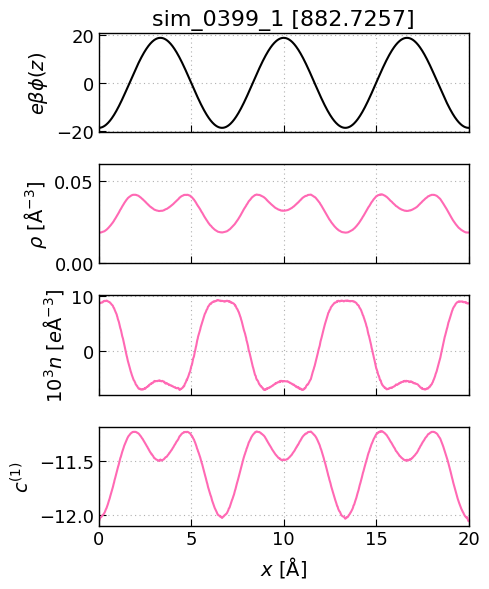

In [5]:
# Select a random simulation
random_sim = random.choice(all_simulations)
#random_sim = 'sim_0954'

# Determine which category the random simulation belongs to
category = next(cat for cat in simData if random_sim in simData[cat])

data = simData[category][random_sim]

z = data['profiles']['xbins']
rho = data['profiles']['rho_O']
muloc = data['profiles']['muloc_O']
elec = data['profiles']['elec']
elec_grad = data['profiles']['elec_grad']
c1 = data['profiles']['c1_O_scaledT']
n = data['profiles']['n']
temp = data['params']['T']


fig, ax = plt.subplots(4, 1, figsize=(5,6), sharex='all')

ax[0].plot(z, elec, label='elec', color='black')

ax[0].set_ylabel(r'$e\beta\phi(z)$')
ax[0].set_title(f'{random_sim} {temp}')

ax[1].plot(z, rho, label='rho', color='hotpink')

ax[2].plot(z, n, label='n', color='hotpink')

ax[3].plot(z, c1, label='c1', color='hotpink')

ax[1].set_ylabel(r'$\rho$ [$\mathrm{\AA}^{-3}$]')

ax[2].set_ylabel(r'$10^3 n$ [$ e\mathrm{\AA}^{-3}$]')


ax[3].set_ylabel(r'$c^{(1)}$')
ax[3].set_xlabel(r'$x$ [$\mathrm{\AA}$]')

ax[2].set_xlim(0, 20)
ax[1].set_ylim(0, 0.06)

place(ax[1])
place(ax[0])
place(ax[2])
place(ax[3])

plt.show()

## Curate data for training, sliding window approach

In [ ]:
import sys
sys.path.append("..")
from data_generators import DataGeneratorThreeInput

def filt(sim):
    temp = sim["params"]["T"]
    return temp > 0.0

# Generator options
generatorOptions = {
    "batch_size": 256,
    "window1Sigma": 10.00,
    "window2Sigma": 10.00,
    "inputKeys1": ["rho_O"],
    "inputKeys2": ["elec"],
    "paramsKeys":["T"],
    "outputKeys": ["n"],
    "binKey": "xbins",
    "filt": filt,
}

# Create data generators
trainingGenerator = DataGeneratorThreeInput(simData["training"], **generatorOptions)
validationGenerator = DataGeneratorThreeInput(simData["validation"], **generatorOptions)



Loaded 2260 simulations
Initialized DataGenerator from 2260 simulations which will yield up to 2260000 input/output samples in batches of 256
Loaded 758 simulations
Initialized DataGenerator from 758 simulations which will yield up to 758000 input/output samples in batches of 256


## Create neural network for model

2026-01-25 13:59:31.242751: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2026-01-25 13:59:31.242811: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: bubbletea
2026-01-25 13:59:31.242819: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: bubbletea
2026-01-25 13:59:31.243034: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 570.211.1
2026-01-25 13:59:31.243066: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 570.195.3
2026-01-25 13:59:31.243072: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 570.195.3 does not match DSO version 570.211.1 -- cannot find working devices in this configuration
/home/btb32/.conda

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ phi (InputLayer)    │ (None, 1001)      │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ gradient_layer      │ (None, 1001)      │       0 │ phi[0][0]            │
│ (GradientLayer)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │  32,064 │ phi[0][0]            │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │ 513,024 │ gradient_layer[0][0] │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      33 │ dense_2[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │     513 │ dense_4[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_1          │ (None, 32)        │       0 │ dense_2[0][0],       │
│ (Multiply)          │                   │         │ dense_3[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_2          │ (None, 512)       │       0 │ dense_4[0][0],       │
│ (Multiply)          │                   │         │ dense_5[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rho (InputLayer)    │ (None, 1001)      │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 544)       │       0 │ multiply_1[0][0],    │
│ (Concatenate)       │                   │         │ multiply_2[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ T (InputLayer)      │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 256)       │ 256,512 │ rho[0][0]            │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │     545 │ concatenate[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     128 │ T[0][0]              │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │     257 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_3          │ (None, 544)       │       0 │ concatenate[0][0],   │
│ (Multiply)          │                   │         │ dense_6[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      65 │ dense_8[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply (Multiply) │ (None, 256)       │       0 │ dense[0][0],         │
│                     │                   │         │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │ 139,520 │ multiply_3[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_4          │ (None, 64)        │       0 │ dense_8[0][0],       │
│ (Multiply)          │                   │         │ dense_9[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_1       │ (None, 576)       │       0 │ multiply[0][0],      │
│ (Concatenate)       │                   │         │ dense_7[0][0],     

 Total params: 1,501,254 (5.73 MB)

 Trainable params: 1,501,254 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

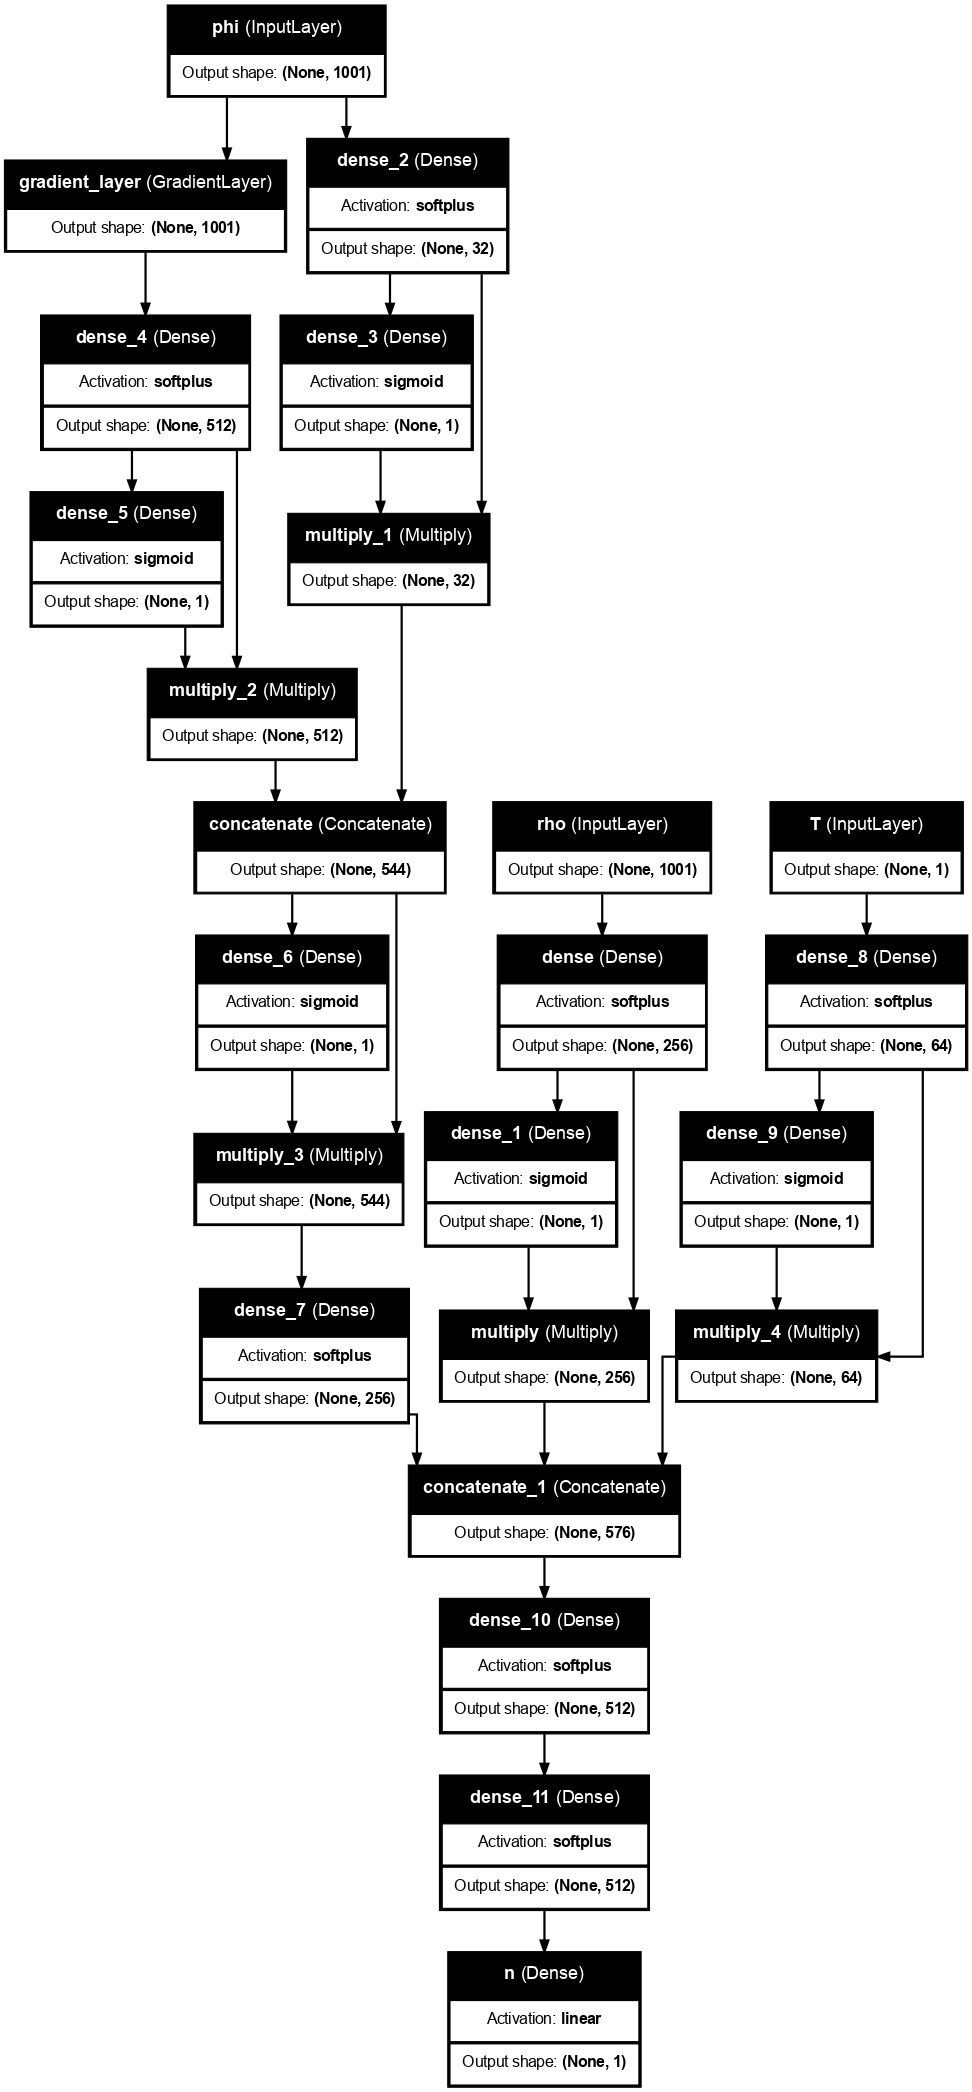

In [7]:
import tensorflow as tf
from tensorflow import keras

# Define a custom layer to compute gradients of `phi` (1D array)
@keras.utils.register_keras_serializable()
class GradientLayer(keras.layers.Layer):
    def call(self, inputs):
        # Compute numerical gradient using central difference (approximated)
        grad = 0.5 * (inputs[:, 2:] - inputs[:, :-2])  # Central difference
        grad = tf.pad(grad, [[0, 0], [1, 1]])  # Pad to keep the same shape
        return grad

# Define the model
profile1Inputs = {"rho_O": keras.Input(shape=trainingGenerator.input1Shape, name="rho")}
profile2Inputs = {"elec": keras.Input(shape=trainingGenerator.input2Shape, name="phi")}
paramsInputs = {"T": keras.Input(shape=(1,), name="T")}  # Temperature input

# L2 regularization
regularizer = keras.regularizers.l2(0.0003)

# Process `rho_O`
x1 = keras.layers.Dense(256, activation="softplus", kernel_regularizer=regularizer)(profile1Inputs["rho_O"])
weight_1 = keras.layers.Dense(1, activation="sigmoid")(x1)
x1 = keras.layers.Multiply()([x1, weight_1])
# Compute gradient of `phi` using custom layer (for 1D input)
grad_phi = GradientLayer()(profile2Inputs["elec"])

# Process both `phi` and its gradient
x2_phi = keras.layers.Dense(32, activation="softplus", kernel_regularizer=regularizer)(profile2Inputs["elec"])
weightphi_2 = keras.layers.Dense(1, activation="sigmoid")(x2_phi)
x2_phi = keras.layers.Multiply()([x2_phi, weightphi_2])

x2_grad = keras.layers.Dense(512, activation="softplus", kernel_regularizer=regularizer)(grad_phi)
weightgrad_2 = keras.layers.Dense(1, activation="sigmoid")(x2_grad)
x2_grad = keras.layers.Multiply()([x2_grad, weightgrad_2])

# Concatenate `phi` and its gradient
x2 = keras.layers.Concatenate()([x2_phi, x2_grad])
weight_2 = keras.layers.Dense(1, activation="sigmoid")(x2)
x2 = keras.layers.Multiply()([x2, weight_2])

# Further process `phi` and gradient combined
x2 = keras.layers.Dense(256, activation="softplus", kernel_regularizer=regularizer)(x2)

# Process `T`
x3 = keras.layers.Dense(64, activation="softplus", kernel_regularizer=regularizer)(paramsInputs["T"])
weight_3 = keras.layers.Dense(1, activation="sigmoid")(x3)
x3 = keras.layers.Multiply()([x3, weight_3])

# Concatenate processed inputs
x = keras.layers.Concatenate()([x1, x2, x3])

# Additional Dense layers
x = keras.layers.Dense(512, activation="softplus", kernel_regularizer=regularizer)(x)
x = keras.layers.Dense(512, activation="softplus", kernel_regularizer=regularizer)(x)

# Output layer
outputs = keras.layers.Dense(trainingGenerator.outputShape[0], name="n")(x)

# Define Model
model = keras.Model(inputs=(profile1Inputs | profile2Inputs | paramsInputs), outputs=outputs)

# Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[keras.metrics.MeanAbsoluteError()]
)

# Print Model Summary
model.summary()

# Visualize Model
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=80)


## Train neural network

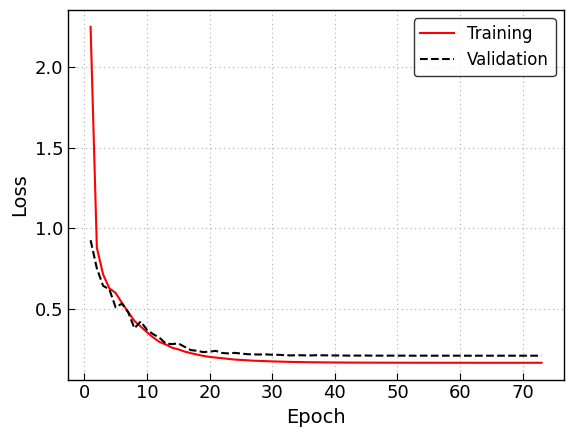

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1660 - mean_absolute_error: 0.0836 - val_loss: 0.2100 - val_mean_absolute_error: 0.1276 - learning_rate: 1.8667e-08


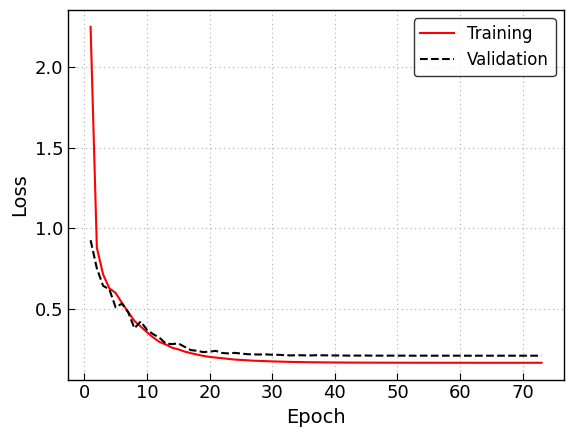

In [ ]:

import callbacks as cb


# Define the callbacks
callbacks = [
    keras.callbacks.LearningRateScheduler(cb.lrschedule),
    keras.callbacks.ModelCheckpoint(
        filepath="../../models/n1_water.keras",
        monitor="val_mean_absolute_error",
        save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor="val_mean_absolute_error",
        patience=20),
    cb.LossHistory()]


# Train the model
model.fit(
    trainingGenerator,
    validation_data=validationGenerator,
    epochs=200,
    callbacks=callbacks
)



In [8]:

#model = keras.models.load_model("../../models/n1_water.keras")
model = keras.models.load_model("../../../bui2026-dielectrocapillarity/models/n1_water_Aug23.keras")

testGenerator = DataGeneratorThreeInput(simData["test"], **generatorOptions)
test_metrics = model.evaluate(testGenerator)


/home/btb32/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:104: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'rho_O' mapping to value <KerasTensor shape=(None, 1001), dtype=float32, sparse=False, name=rho> which has name 'rho'. Change the tensor name to 'rho_O' (via `Input(..., name='rho_O')`)
  warnings.warn(
/home/btb32/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:104: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'elec' mapping to value <KerasTensor shape=(None, 1001), dtype=float32, sparse=False, name=phi> which has name 'phi'. Change the tensor name to 'elec' (via `Input(..., name='elec')`)
  warnings.warn(


Loaded 718 simulations
Initialized DataGenerator from 718 simulations which will yield up to 718000 input/output samples in batches of 256


I0000 00:00:1769349606.932971 4163699 service.cc:145] XLA service 0x7f18a800c420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769349606.933069 4163699 service.cc:153]   StreamExecutor device (0): Host, Default Version
2026-01-25 14:00:06.965662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   9/2804 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.2284 - mean_absolute_error: 0.1460  

I0000 00:00:1769349607.239422 4163699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2804/2804 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.2402 - mean_absolute_error: 0.1577


## See the predicted correlation function of test set

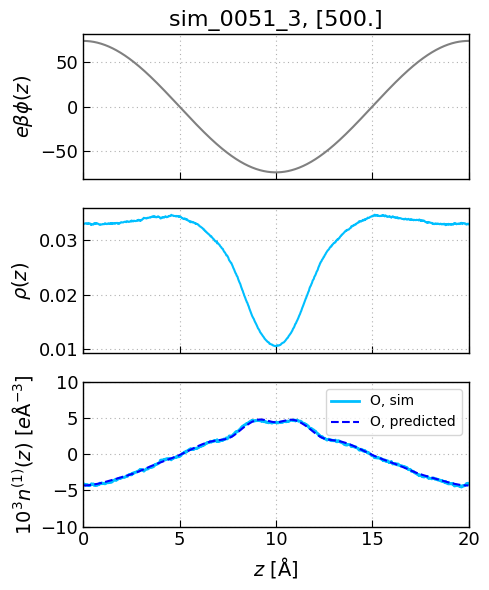

In [ ]:

def generate_windows(array, bins, mode="wrap"):

    padded_array = np.pad(array, bins, mode=mode)
    windows = np.empty((len(array), 2 * bins + 1))
    for i in range(len(array)):
        windows[i] = padded_array[i:i + 2 * bins + 1]
    return windows


def get_charge_density(model, density_profile, elec, params):
    input_bins = model.input_shape[1][1]

    window_bins = (input_bins - 1) // 2
    rho_windows = generate_windows(density_profile, window_bins).reshape(density_profile.shape[0], input_bins, 1)
    elec_windows = generate_windows(elec, window_bins).reshape(elec.shape[0], input_bins, 1)
    
    paramsInput = {key: tf.convert_to_tensor(np.full(density_profile.shape[0], value)) for key, value in params.items()}
    return model.predict_on_batch({"rho_O": rho_windows, "elec": elec_windows, **paramsInput}).flatten()


# Combine all tests simulations into one list
all_test_simulations = []
for category in ['test']:
    all_test_simulations.extend(list(simData[category].keys()))


# Select a random simulation
random_sim = random.choice(all_test_simulations)

# Determine which category the random simulation belongs to
category = next(cat for cat in simData if random_sim in simData[cat])


# Get the data for the random simulation
data = simData[category][random_sim]

# Extract z, rho, muloc, and c1
xbins = data['profiles']['xbins']
rho = data['profiles']['rho_O']
muloc = data['profiles']['muloc_O']
elec = data['profiles']['elec']
elec_grad = data['profiles']['elec_grad']
n_sim = data['profiles']['n']
n = data['profiles']['n']
temp = data['params']['T']

fig, ax = plt.subplots(3, 1, figsize=(5,6), sharex='all')

ax[0].plot(xbins, elec, label='phi', color='gray')


ax[0].set_ylabel(r'$e\beta\phi(z)$')
ax[0].set_title(f'{random_sim}, {temp}')


ax[1].plot(xbins, rho, label='O', color='deepskyblue')


ax[2].plot(xbins, n_sim, label='O, sim', color='deepskyblue', lw=2)

n_pred = get_charge_density(model, rho, elec, {"T": temp})
ax[2].plot(xbins, n_pred, label='O, predicted', color='blue', ls='--')


ax[1].set_ylabel(r'$\rho(z)$')
ax[2].set_ylabel(r'$10^3 n^\mathrm{(1)}(z)$ [$ e\mathrm{\AA}^{-3}$]')
ax[2].set_xlabel(r'$z$ [$\mathrm{\AA}$]')

ax[2].legend()
ax[2].set_xlim(0, 20)
ax[2].set_ylim(-10, 10)


place(ax[0])
place(ax[1])
place(ax[2])

plt.show()